# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter=lambda variableId: 
                                                    variableId.startswith('observable_') and not variableId.endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': 'x1', 'observable_x2': 'x2', 'observable_x3': 'x3', 'observable_x1_scaled': 'scaling_x1 * x1', 'observable_x2_offsetted': 'offset_x2 + x2', 'observable_x1withsigma': 'x1'}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'t': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 0.41721488, 0.6707597 ],
       [0.15106393, 0.43460508, 0.64095895],
       [0.20141095, 0.46753068, 0.58381562],
       [0.291

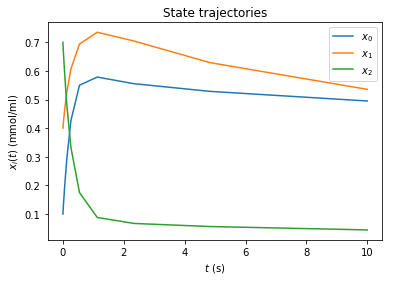

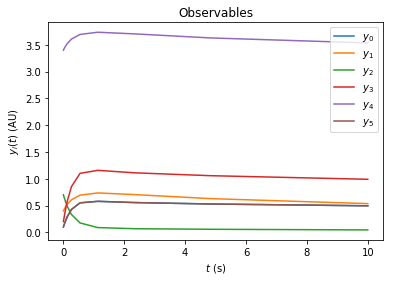

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [8]:
expectedLlh = 0.0
sigma_default = 0.1 # parameters are lin
sigma_parameter = 1e8#0.2
offset_batch_1 = 3.0
offset_batch_2 = 4.0
offsetted_observable_idx = 4
sigma_parameter_observable_idx = 5
model_offset_parameter_idx = 6
sigma_parameter_idx = 7
timepoints = np.logspace(-5, 1, 20)

model = modelModule.getModel()
default_parameters = np.array(model.getParameters())
default_parameters[sigma_parameter_idx] = sigma_parameter
true_parameters = default_parameters
true_parameters = np.append(true_parameters, offset_batch_2) # add second offset parameter
print('true_parameters: %s' % true_parameters)

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(timepoints))
    model.setParameters(amici.DoubleVector(default_parameters))
    print('Default parameters: ', default_parameters)
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    conditions.append(conditions[0] * 1.1)
    conditions.append(conditions[0] * 1.2)
    conditions.append(conditions[0] * 1.3)

    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        
        # different offset for two "batches"
        batch_id = icondition % 2
        if batch_id == 0:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_1
        else:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_2
        
        sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
        sigmay[:, sigma_parameter_observable_idx] = np.nan # observable with sigma parameter
        
        # simulate condition
        rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)
        
        print('\tllh: ', rdata['llh'])
        print('\tsllh', rdata['sllh'])

        expectedLlh += rdata['llh']
        
        conditionName = 'condition-%d' % icondition
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            scalingParameter = [''] 
            sigma = sigmay[:, iy]
            
            if observableName == 'observable_x1_scaled':
                #scalingParameter = ['scaling_x1_%s' % conditionName]
                scalingParameter = ['scaling_x1_common']
            elif observableName == 'observable_x2_offsetted':
                #scalingParameter = ['offset_x2_%s' % conditionName]
                #scalingParameter = ['offset_x2_common']
                scalingParameter = ['offset_x2_batch-%d' % batch_id]
            elif observableName == 'observable_x1withsigma':
                #scalingParameter = ['observable_x1withsigma_sigma_%s' % conditionName]
                scalingParameter = ['observable_x1withsigma_sigma_common']
            
            df = df.append(pd.DataFrame(
            {'observable'      : [observableName] * model.nt(),
             'condition'       : [conditionName]  * model.nt(),
             'conditionRef'    : ['']  * model.nt(),
             'scalingParameter': scalingParameter * model.nt(),
             'time'            : np.array(model.getTimepoints()),
             'measurement'     : rdata['y'][:, iy],
             'sigma'           : sigma
             }), ignore_index=True)
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    #measurement = np.random.normal(loc=rdata['y'], scale=np.sqrt(sigmay))
    #print((measurement-rdata['y'])/rdata['y'])
    #measurement[:, sigma_parameter_observable_idx] = np.random.normal(
    #    loc=rdata['y'][:, sigma_parameter_observable_idx], 
    #    scale=np.sqrt(simulationParameters[sigma_parameter_idx]))

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    
    return rdata

df, conditionDf = createData()

true_parameters: [1.e+00 5.e-01 4.e-01 2.e+00 1.e-01 2.e+00 3.e+00 1.e+08 4.e+00]
Default parameters:  [1.e+00 5.e-01 4.e-01 2.e+00 1.e-01 2.e+00 3.e+00 1.e+08]
Condition 0: [1.]
	llh:  -248.42772956420313
	sllh [-1.19681450e-06 -1.30721325e-06  3.98056903e-06  1.46667403e-06
  5.66724216e-06  2.40838267e-06  3.97264106e-06 -2.00000000e-07]
Condition 1: [1.1]
	llh:  -248.42772956420293
	sllh [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-07]
Condition 2: [1.2]
	llh:  -248.42772956420293
	sllh [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-07]
Condition 3: [1.3]
	llh:  -248.42772956420293
	sllh [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-07]
Expected llh:  -993.710918256812


In [9]:
df

,condition,conditionRef,measurement,observable,scalingParameter,sigma,time
0,condition-0,,0.100018,observable_x1,,0.1,0.000010
1,condition-0,,0.100037,observable_x1,,0.1,0.000021
2,condition-0,,0.100076,observable_x1,,0.1,0.000043
3,condition-0,,0.100158,observable_x1,,0.1,0.000089
4,condition-0,,0.100326,observable_x1,,0.1,0.000183
5,condition-0,,0.100675,observable_x1,,0.1,0.000379
6,condition-0,,0.101396,observable_x1,,0.1,0.000785
7,condition-0,,0.102885,observable_x1,,0.1,0.001624
8,condition-0,,0.105956,observable_x1,,0.1,0.003360
9,condition-0,,0.112270,observable_x1,,0.1,0.006952


In [10]:
conditionDf

,ID,condition-0,condition-1,condition-2,condition-3
k0,k0,1.0,1.1,1.2,1.3


In [11]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
assert out.returncode==0


Measurements shape (480, 7)
Changing t = Inf to t = 1e8.
Num conditions:  4
Num timepoints:  20 [1e-05, 2.0691380811147897e-05, 4.281332398719396e-05, 8.858667904100833e-05, 0.0001832980710832436, 0.000379269019073225, 0.0007847599703514606, 0.001623776739188721, 0.003359818286283781, 0.006951927961775605, 0.014384498882876632, 0.029763514416313162, 0.061584821106602614, 0.1274274985703132, 0.26366508987303555, 0.5455594781168515, 1.1288378916846884, 2.3357214690901213, 4.832930238571752, 10.0]
Fixed parameters orginal:  (1, 4)
Fixed parameters usable:  (1, 4)
Generate parameter list...
Number of simulation parameters: 8
Number of optimization parameters: 9
Generating fixed parameters matrix...
Number of fixed parameters: 1
Generating measurement matrix...
Number of observables: 6
Handling scaling parameters...
Ensure that scaling_x1_common is selected correctly as proportionality factor for hierarchical optimization ().
Number of proportionality factors for hierarchical optimization: 

In [12]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    for i in range(10):
        parameters = np.log10(true_parameters)
        # offset parameters are not log10
        parameters[model_offset_parameter_idx] = 10**parameters[model_offset_parameter_idx]
        parameters[model_offset_parameter_idx+2] = 10**parameters[model_offset_parameter_idx+2]
        #parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters


In [13]:
# enable derivate checker
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes

!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Gradient check

In [14]:
for i in range(3):
    !PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deleteme/ example_data.h5


[2018-06-28 00:13:24] [ERR] [-1/]     0 g:  1.61781e+10  fd_c:            0  Δ/fd_c: 1.617808e+15  f:  9.18189e+22
[2018-06-28 00:13:24] [ERR] [-1/]     1 g:   -3.002e+07  fd_c:            0  Δ/fd_c: -3.001995e+12  f:  9.18189e+22
[2018-06-28 00:13:24] [ERR] [-1/]     2 g: -1.20415e+11  fd_c:            0  Δ/fd_c: -1.204151e+16  f:  9.18189e+22
[2018-06-28 00:13:24] [ERR] [-1/]     3 g:  1.81029e+08  fd_c:            0  Δ/fd_c: 1.810294e+13  f:  9.18189e+22
[2018-06-28 00:13:24] [ERR] [-1/]     4 g:   7.0113e+08  fd_c:            0  Δ/fd_c: 7.011302e+13  f:  9.18189e+22
[2018-06-28 00:13:24] [ERR] [-1/]     5 g:  2.57993e+08  fd_c:            0  Δ/fd_c: 2.579925e+13  f:  9.18189e+22
[2018-06-28 00:13:24] [ERR] [-1/]     6 g:  1.99878e+13  fd_c:            0  Δ/fd_c: 1.998781e+18  f:  9.18189e+22
[2018-06-28 00:13:24] [ERR] [-1/]     7 g: -9.96893e+07  fd_c:            0  Δ/fd_c: -9.968935e+12  f:  9.18189e+22
[2018-06-28 00:13:24] [ERR] [-1/]     8 g: -1.83041e+13  fd_c:            0  

## Optimize

In [15]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme/ example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
Scanning dependencies of target model_steadystate_scaled
[  7%] Built target parpecommon
-- Found Git: /usr/bin/git (found version "2.17.1") 
[  7%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JDiag.cpp.o
-- Building version parPE-v0.1.7-50-gaa7b5-dirty
[  8%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparse.cpp.o
[  9%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_J.cpp.o
[ 12%] Built target parpeloadbalancer
[ 10%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JB.cpp.o
[ 15%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_stead

[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.0 (0): -44409.6 (0) (0.0397s)
[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.1 (1): -24111.6 (0) (0.0295s)
[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.2 (2): -44272.9 (0) (0.0250s)
[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.3 (3): -24167.7 (0) (0.0286s)
Starting derivative checker for first derivatives.

[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.0 (0): -44409.6 (0) (0.0020s)
[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.1 (1): -24111.6 (0) (0.0023s)
[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.2 (2): -44272.9 (0) (0.0022s)
[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.3 (3): -24167.7 (0) (0.0024s)
* grad_f[          0] = -1.4827735804240422e-01    ~ -1.4654944973650391e-01  [ 1.728e-03]
[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.0 (0): -44409.6 (0) (0.0020s)
[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.0.0.1 (1): -24111.6 (0) (0.0022s)
[2018-06-28 00:13:45] [DBG] [-1/] Result for 0.

[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.0 (0): -1567.08 (0) (0.0123s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.1 (1): -1490.35 (0) (0.0127s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.2 (2): -1565 (0) (0.0127s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.3 (3): -1488.36 (0) (0.0129s)
[2018-06-28 00:13:46] [INF] [-1/] iter: 2 cost: 6110.79 time_iter: 0.114869s time_optim: 0.650397s
   2  6.1107917e+03 0.00e+00 1.23e+06   7.2 4.93e+03    -  1.00e+00 2.45e-04f  3
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.0 (0): -349.9 (0) (0.0013s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.1 (1): -336.869 (0) (0.0012s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.2 (2): -333 (0) (0.0012s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.3 (3): -321.541 (0) (0.0013s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.0 (0): -349.9 (0) (0.0128s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.1 (1): -336.869 (0) (0.0128s)
[2018-06-28 00:13:46]

[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.0 (0): 15.7058 (0) (0.0099s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.1 (1): 16.9106 (0) (0.0102s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.2 (2): 15.1876 (0) (0.0095s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.3 (3): 16.3709 (0) (0.0092s)
[2018-06-28 00:13:46] [INF] [-1/] iter: 10 cost: -64.1749 time_iter: 0.101739s time_optim: 1.25206s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -6.4174902e+01 0.00e+00 8.77e+02   1.5 2.02e+00    -  9.96e-01 1.25e-01f  4
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.0 (0): -135511 (0) (0.0015s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.1 (1): -129283 (0) (0.0014s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.2 (2): -135380 (0) (0.0016s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.3 (3): -129162 (0) (0.0017s)
[2018-06-28 00:13:46] [DBG] [-1/] Result for 0.0.0.0 (0): -135511 (0) (0.0014s)
[2018-06-28 00:13:

[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.3 (3): 131.721 (0) (0.0177s)
[2018-06-28 00:13:47] [INF] [-1/] iter: 16 cost: -525.18 time_iter: 0.0974064s time_optim: 1.73783s
  16 -5.2517995e+02 0.00e+00 1.48e+02  -4.3 1.68e-01    -  1.00e+00 1.00e+00f  1
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.0 (0): 163.939 (0) (0.0013s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.1 (1): 163.919 (0) (0.0014s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.2 (2): 163.84 (0) (0.0013s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.3 (3): 163.88 (0) (0.0015s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.0 (0): 163.939 (0) (0.0175s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.1 (1): 163.919 (0) (0.0135s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.2 (2): 163.84 (0) (0.0129s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.3 (3): 163.88 (0) (0.0156s)
[2018-06-28 00:13:47] [INF] [-1/] iter: 17 cost: -655.578 time_iter: 0.101806s time_optim: 1.83963s
  1

[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.1 (1): 189.029 (0) (0.0121s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.2 (2): 189.117 (0) (0.0141s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.3 (3): 189.256 (0) (0.0124s)
[2018-06-28 00:13:47] [INF] [-1/] iter: 21 cost: -756.097 time_iter: 0.0836615s time_optim: 2.27715s
  21 -7.5609718e+02 0.00e+00 1.75e+02  -7.9 1.16e-01    -  1.00e+00 1.00e+00f  1
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.0 (0): 148.136 (0) (0.0013s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.1 (1): 149.748 (0) (0.0013s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.2 (2): 150.784 (0) (0.0013s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.3 (3): 151.868 (0) (0.0013s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.0 (0): 148.136 (0) (0.0013s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.1 (1): 149.748 (0) (0.0013s)
[2018-06-28 00:13:47] [DBG] [-1/] Result for 0.0.0.2 (2): 150.784 (0) (0.0013s)
[2018-06-28 00:13:

[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.2 (2): 213.269 (0) (0.0127s)
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.3 (3): 211.461 (0) (0.0191s)
[2018-06-28 00:13:48] [INF] [-1/] iter: 27 cost: -856.378 time_iter: 0.126817s time_optim: 2.85417s
  27 -8.5637779e+02 0.00e+00 2.03e+02 -10.5 1.41e+01    -  1.00e+00 1.20e-02f  5
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.0 (0): 218.201 (0) (0.0015s)
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.1 (1): 219.983 (0) (0.0014s)
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.2 (2): 220.962 (0) (0.0013s)
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.3 (3): 221.189 (0) (0.0014s)
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.0 (0): 218.201 (0) (0.0180s)
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.1 (1): 219.983 (0) (0.0162s)
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.2 (2): 220.962 (0) (0.0122s)
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.3 (3): 221.189 (0) (0.0112s)
[2018-06-28 00:13:4

[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.1 (1): 229.951 (0) (0.0129s)
[2018-06-28 00:13:48] [DBG] [-1/] Result for 0.0.0.2 (2): 226.942 (0) (0.0153s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.3 (3): 222.808 (0) (0.0153s)
[2018-06-28 00:13:49] [INF] [-1/] iter: 34 cost: -911.336 time_iter: 0.110858s time_optim: 3.49663s
  34 -9.1133641e+02 0.00e+00 9.92e+02 -11.0 2.84e-01    -  1.00e+00 2.50e-01f  3
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.0 (0): 223.189 (0) (0.0014s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.1 (1): 223.8 (0) (0.0014s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.2 (2): 223.388 (0) (0.0013s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.3 (3): 222.399 (0) (0.0014s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.0 (0): 223.189 (0) (0.0014s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.1 (1): 223.8 (0) (0.0010s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.2 (2): 223.388 (0) (0.0009s)
[2018-06-28 00:13:49] [

[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.0 (0): 233.182 (0) (0.0127s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.1 (1): 234.529 (0) (0.0123s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.2 (2): 234.395 (0) (0.0119s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.3 (3): 234.799 (0) (0.0120s)
[2018-06-28 00:13:49] [INF] [-1/] iter: 38 cost: -936.906 time_iter: 0.120109s time_optim: 3.90886s
  38 -9.3690568e+02 0.00e+00 1.64e+03 -10.2 2.89e+01    -  1.00e+00 2.50e-03f  6
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.0 (0): 221.531 (0) (0.0011s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.1 (1): 222.411 (0) (0.0009s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.2 (2): 223.053 (0) (0.0009s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.3 (3): 224.067 (0) (0.0010s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.0 (0): 221.531 (0) (0.0009s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.1 (1): 222.411 (0) (0.0009s)
[2018-06-28 00:13:4

[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.0 (0): 239.332 (0) (0.0120s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.1 (1): 240.485 (0) (0.0109s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.2 (2): 241.53 (0) (0.0111s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.3 (3): 242.327 (0) (0.0110s)
[2018-06-28 00:13:49] [INF] [-1/] iter: 42 cost: -963.673 time_iter: 0.108989s time_optim: 4.36589s
  42 -9.6367311e+02 0.00e+00 6.21e+03 -10.5 1.44e+01    -  1.00e+00 9.44e-03f  5
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.0 (0): -1.52333e+06 (0) (0.0010s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.1 (1): -1.61873e+06 (0) (0.0009s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.2 (2): -1.74033e+06 (0) (0.0009s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.3 (3): -1.88313e+06 (0) (0.0010s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.0 (0): -1.52333e+06 (0) (0.0009s)
[2018-06-28 00:13:49] [DBG] [-1/] Result for 0.0.0.1 (1): -1.61873e+06 (0) 

[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.1 (1): 248.385 (0) (0.0125s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.2 (2): 246.627 (0) (0.0152s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.3 (3): 243.72 (0) (0.0108s)
[2018-06-28 00:13:50] [INF] [-1/] iter: 45 cost: -986.282 time_iter: 0.134352s time_optim: 4.71373s
  45 -9.8628200e+02 0.00e+00 1.40e+04  -8.1 1.61e+02    -  1.00e+00 1.63e-04f  7
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.0 (0): -1.42335e+08 (0) (0.0009s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.1 (1): -1.45032e+08 (0) (0.0009s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.2 (2): -1.47997e+08 (0) (0.0012s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.3 (3): -1.51139e+08 (0) (0.0013s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.0 (0): -1.42335e+08 (0) (0.0009s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.1 (1): -1.45032e+08 (0) (0.0009s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.2 (2): -1.47997e+08

[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.1 (1): 251.524 (0) (0.0152s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.2 (2): 247.336 (0) (0.0118s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.3 (3): 243.084 (0) (0.0111s)
[2018-06-28 00:13:50] [INF] [-1/] iter: 48 cost: -994.326 time_iter: 0.133771s time_optim: 5.0825s
  48 -9.9432585e+02 0.00e+00 8.61e+03  -4.3 6.34e+00    -  1.00e+00 4.24e-03f  8
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.0 (0): -548144 (0) (0.0009s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.1 (1): -547658 (0) (0.0009s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.2 (2): -542494 (0) (0.0009s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.3 (3): -532872 (0) (0.0009s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.0 (0): -548144 (0) (0.0009s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.1 (1): -547658 (0) (0.0010s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.2 (2): -542494 (0) (0.0009s)
[2018-06-28 00:13:50

[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.2 (2): 261.497 (0) (0.0140s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.3 (3): 257.389 (0) (0.0136s)
[2018-06-28 00:13:50] [INF] [-1/] iter: 51 cost: -1053.55 time_iter: 0.107343s time_optim: 5.42303s
  51 -1.0535453e+03 0.00e+00 1.23e+04  -2.5 3.00e+03    -  5.10e-03 7.11e-05f  4
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.0 (0): -10256.8 (0) (0.0020s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.1 (1): -9024.52 (0) (0.0016s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.2 (2): -10223.5 (0) (0.0017s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.3 (3): -8996.65 (0) (0.0014s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.0 (0): -10256.8 (0) (0.0013s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.1 (1): -9024.52 (0) (0.0017s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.2 (2): -10223.5 (0) (0.0014s)
[2018-06-28 00:13:50] [DBG] [-1/] Result for 0.0.0.3 (3): -8996.65 (0) (0.0014s)
[2018-06-28

[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.0 (0): -2.69235e+06 (0) (0.0009s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.1 (1): -2.82781e+06 (0) (0.0009s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.2 (2): -2.98332e+06 (0) (0.0015s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.3 (3): -3.15589e+06 (0) (0.0012s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.0 (0): -5922.22 (0) (0.0014s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.1 (1): -6431.27 (0) (0.0013s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.2 (2): -7063.4 (0) (0.0014s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.3 (3): -7792.69 (0) (0.0013s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.0 (0): 181.213 (0) (0.0010s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.1 (1): 177.453 (0) (0.0013s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.2 (2): 169.991 (0) (0.0013s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.3 (3): 163.209 (0) (0.0015s)
[2018-06-28 00:13

[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.2 (2): 260.779 (0) (0.0009s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.3 (3): 261.115 (0) (0.0012s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.0 (0): 267.244 (0) (0.0012s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.1 (1): 265.769 (0) (0.0010s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.2 (2): 263.64 (0) (0.0009s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.3 (3): 263.303 (0) (0.0012s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.0 (0): 267.961 (0) (0.0009s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.1 (1): 266.279 (0) (0.0010s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.2 (2): 263.95 (0) (0.0009s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.3 (3): 263.188 (0) (0.0010s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.0 (0): 267.961 (0) (0.0115s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.1 (1): 266.279 (0) (0.0119s)
[2018-06-28 00:13:51] [DBG] [-1/] Result f

[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.2 (2): 263.589 (0) (0.0151s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.3 (3): 262.536 (0) (0.0150s)
[2018-06-28 00:13:51] [INF] [-1/] iter: 58 cost: -1060.72 time_iter: 0.158997s time_optim: 6.37922s
  58 -1.0607226e+03 0.00e+00 5.62e+03   1.6 7.66e+00    -  5.86e-01 6.78e-04f 10
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.0 (0): -2150.17 (0) (0.0014s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.1 (1): -1866.25 (0) (0.0011s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.2 (2): -2141.4 (0) (0.0011s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.3 (3): -1858.73 (0) (0.0011s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.0 (0): -2150.17 (0) (0.0017s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.1 (1): -1866.25 (0) (0.0017s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.2 (2): -2141.4 (0) (0.0014s)
[2018-06-28 00:13:51] [DBG] [-1/] Result for 0.0.0.3 (3): -1858.73 (0) (0.0016s)
[2018-06-28 0

[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.0 (0): 277.091 (0) (0.0121s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.1 (1): 276.853 (0) (0.0113s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.2 (2): 276.573 (0) (0.0114s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.3 (3): 276.29 (0) (0.0107s)
[2018-06-28 00:13:52] [INF] [-1/] iter: 61 cost: -1106.81 time_iter: 0.115586s time_optim: 6.7608s
  61 -1.1068072e+03 0.00e+00 1.95e+04   1.9 5.97e+00    -  1.00e+00 1.07e-02f  6
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.0 (0): -1.02893e+08 (0) (0.0011s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.1 (1): -1.00866e+08 (0) (0.0011s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.2 (2): -9.90368e+07 (0) (0.0011s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.3 (3): -9.7367e+07 (0) (0.0011s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.0 (0): -1.02893e+08 (0) (0.0013s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.1 (1): -1.00866e+08 (0) (0

[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.1 (1): -203.545 (0) (0.0117s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.2 (2): -226.759 (0) (0.0150s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.3 (3): -193.146 (0) (0.0124s)
[2018-06-28 00:13:52] [INF] [-1/] iter: 64 cost: 861.487 time_iter: 0.0957393s time_optim: 7.12139s
  64  8.6148747e+02 0.00e+00 8.06e+02   3.2 4.97e+00    -  1.00e+00 5.00e-01f  2
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.0 (0): -3171.19 (0) (0.0013s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.1 (1): -2848.88 (0) (0.0013s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.2 (2): -3146.75 (0) (0.0012s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.3 (3): -2826.37 (0) (0.0010s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.0 (0): -3171.19 (0) (0.0013s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.1 (1): -2848.88 (0) (0.0013s)
[2018-06-28 00:13:52] [DBG] [-1/] Result for 0.0.0.2 (2): -3146.75 (0) (0.0013s)
[2018-06-

[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.2 (2): 213.383 (0) (0.0116s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.3 (3): 213.27 (0) (0.0110s)
[2018-06-28 00:13:53] [INF] [-1/] iter: 68 cost: -853.305 time_iter: 0.0961627s time_optim: 7.51268s
  68 -8.5330533e+02 0.00e+00 1.09e+02   1.1 2.56e+00    -  6.57e-01 2.50e-01f  3
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.0 (0): -1.05826e+07 (0) (0.0010s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.1 (1): -1.07576e+07 (0) (0.0009s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.2 (2): -1.09168e+07 (0) (0.0010s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.3 (3): -1.10647e+07 (0) (0.0010s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.0 (0): -1.05826e+07 (0) (0.0010s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.1 (1): -1.07576e+07 (0) (0.0009s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.2 (2): -1.09168e+07 (0) (0.0009s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.3 (3): -1.106

[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.2 (2): 245.427 (0) (0.0010s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.3 (3): 244.225 (0) (0.0012s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.0 (0): 246.465 (0) (0.0009s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.1 (1): 245.951 (0) (0.0010s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.2 (2): 246.018 (0) (0.0009s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.3 (3): 245.474 (0) (0.0011s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.0 (0): 246.465 (0) (0.0114s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.1 (1): 245.951 (0) (0.0121s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.2 (2): 246.018 (0) (0.0123s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.3 (3): 245.474 (0) (0.0141s)
[2018-06-28 00:13:53] [INF] [-1/] iter: 71 cost: -983.908 time_iter: 0.135455s time_optim: 7.86694s
  71 -9.8390787e+02 0.00e+00 1.83e+03   1.1 3.33e+00    -  1.00e+00 7.70e-03f  8
[2018-06-28 00:13:5

[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.0 (0): 261.233 (0) (0.0133s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.1 (1): 261.066 (0) (0.0144s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.2 (2): 260.882 (0) (0.0115s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.3 (3): 260.843 (0) (0.0125s)
[2018-06-28 00:13:53] [INF] [-1/] iter: 75 cost: -1044.02 time_iter: 0.118951s time_optim: 8.31832s
  75 -1.0440246e+03 0.00e+00 6.87e+03   1.1 4.14e-01    -  9.82e-01 6.25e-02f  5
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.0 (0): 38.2572 (0) (0.0013s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.1 (1): 21.1553 (0) (0.0011s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.2 (2): 38.9719 (0) (0.0009s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.3 (3): 22.0523 (0) (0.0010s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.0 (0): 38.2572 (0) (0.0012s)
[2018-06-28 00:13:53] [DBG] [-1/] Result for 0.0.0.1 (1): 21.1553 (0) (0.0010s)
[2018-06-28 00:13:5

[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.1 (1): 241.061 (0) (0.0011s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.2 (2): 240.705 (0) (0.0013s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.3 (3): 242.547 (0) (0.0013s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.0 (0): 262.387 (0) (0.0013s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.1 (1): 262.881 (0) (0.0012s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.2 (2): 263.221 (0) (0.0012s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.3 (3): 263.549 (0) (0.0009s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.0 (0): 262.387 (0) (0.0114s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.1 (1): 262.881 (0) (0.0129s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.2 (2): 263.221 (0) (0.0129s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.3 (3): 263.549 (0) (0.0129s)
[2018-06-28 00:13:54] [INF] [-1/] iter: 78 cost: -1052.04 time_iter: 0.131267s time_optim: 8.69212s
  78 -1.0520377e+03 

[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.2 (2): -8125.5 (0) (0.0012s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.3 (3): -8792.67 (0) (0.0014s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.0 (0): 195.034 (0) (0.0012s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.1 (1): 191.253 (0) (0.0011s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.2 (2): 183.767 (0) (0.0009s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.3 (3): 175.987 (0) (0.0012s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.0 (0): 271.892 (0) (0.0009s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.1 (1): 272.358 (0) (0.0009s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.2 (2): 271.257 (0) (0.0009s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.3 (3): 271.675 (0) (0.0009s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.0 (0): 271.892 (0) (0.0117s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.1 (1): 272.358 (0) (0.0111s)
[2018-06-28 00:13:54] [DBG] [-1/] Resul

[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.0 (0): 277.167 (0) (0.0013s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.1 (1): 276.518 (0) (0.0013s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.2 (2): 274.442 (0) (0.0013s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.3 (3): 272.34 (0) (0.0013s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.0 (0): 284.466 (0) (0.0012s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.1 (1): 283.914 (0) (0.0012s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.2 (2): 283.23 (0) (0.0013s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.3 (3): 282.523 (0) (0.0013s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.0 (0): 284.466 (0) (0.0149s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.1 (1): 283.914 (0) (0.0112s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.2 (2): 283.23 (0) (0.0117s)
[2018-06-28 00:13:54] [DBG] [-1/] Result for 0.0.0.3 (3): 282.523 (0) (0.0114s)
[2018-06-28 00:13:54] [INF] [-1/] iter: 84 

[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.1 (1): 285.676 (0) (0.0124s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.2 (2): 284.785 (0) (0.0118s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.3 (3): 283.882 (0) (0.0125s)
[2018-06-28 00:13:55] [INF] [-1/] iter: 86 cost: -1140.76 time_iter: 0.130984s time_optim: 9.69042s
  86 -1.1407567e+03 0.00e+00 7.64e+03   1.3 9.07e-01    -  1.00e+00 1.56e-02f  7
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.0 (0): -669651 (0) (0.0009s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.1 (1): -705714 (0) (0.0010s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.2 (2): -751579 (0) (0.0012s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.3 (3): -800980 (0) (0.0014s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.0 (0): -669651 (0) (0.0009s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.1 (1): -705714 (0) (0.0009s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.2 (2): -751579 (0) (0.0009s)
[2018-06-28 00:13:5

[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.1 (1): 290.777 (0) (0.0116s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.2 (2): 292.831 (0) (0.0132s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.3 (3): 289.666 (0) (0.0112s)
[2018-06-28 00:13:55] [INF] [-1/] iter: 89 cost: -1167.13 time_iter: 0.103566s time_optim: 10.0535s
  89 -1.1671289e+03 0.00e+00 4.32e+04  -1.3 2.84e-01    -  1.00e+00 2.50e-01f  3
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.0 (0): -5.46458e+07 (0) (0.0010s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.1 (1): -5.59331e+07 (0) (0.0010s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.2 (2): -5.71467e+07 (0) (0.0011s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.3 (3): -5.82828e+07 (0) (0.0014s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.0 (0): -5.46458e+07 (0) (0.0013s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.1 (1): -5.59331e+07 (0) (0.0014s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.2 (2): -5.71467e+0

[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.1 (1): -104093 (0) (0.0011s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.2 (2): -106546 (0) (0.0013s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.3 (3): -106430 (0) (0.0051s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.0 (0): -11139.7 (0) (0.0013s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.1 (1): -10980.4 (0) (0.0014s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.2 (2): -11322.9 (0) (0.0014s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.3 (3): -11067.6 (0) (0.0014s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.0 (0): -1253.44 (0) (0.0013s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.1 (1): -1135.13 (0) (0.0014s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.2 (2): -1167.22 (0) (0.0013s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.3 (3): -1063.93 (0) (0.0015s)
[2018-06-28 00:13:55] [DBG] [-1/] Result for 0.0.0.0 (0): -11.6171 (0) (0.0009s)
[2018-06-28 00:13:55] [DBG] [-1

[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.0 (0): -189814 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.1 (1): -184780 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.2 (2): -193326 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.3 (3): -189623 (0) (0.0014s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.0 (0): -10145 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.1 (1): -8487 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.2 (2): -10225.8 (0) (0.0012s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.3 (3): -8694.96 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.0 (0): -880.162 (0) (0.0012s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.1 (1): -431.288 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.2 (2): -879.666 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.3 (3): -447.286 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Res

[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.0 (0): -166238 (0) (0.0013s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.1 (1): -355846 (0) (0.0015s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.2 (2): -166250 (0) (0.0014s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.3 (3): -355871 (0) (0.0014s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.0 (0): -41527.2 (0) (0.0010s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.1 (1): -88736.8 (0) (0.0011s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.2 (2): -41505 (0) (0.0010s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.3 (3): -88718.9 (0) (0.0011s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.0 (0): -10705 (0) (0.0010s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.1 (1): -22398.5 (0) (0.0010s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.2 (2): -10664.2 (0) (0.0010s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.3 (3): -22360.1 (0) (0.0010s)
[2018-06-28 00:13:56] [DBG] [-1/] Re

[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.0 (0): 245.022 (0) (0.0132s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.1 (1): 211.797 (0) (0.0128s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.2 (2): 229.437 (0) (0.0145s)
[2018-06-28 00:13:56] [DBG] [-1/] Result for 0.0.0.3 (3): 191.167 (0) (0.0150s)
[2018-06-28 00:13:57] [INF] [-1/] iter: 98 cost: -877.424 time_iter: 0.107331s time_optim: 11.4959s
  98 -8.7742364e+02 0.00e+00 3.90e+04   2.9 7.58e-01    -  1.00e+00 5.00e-01f  2
[2018-06-28 00:13:57] [DBG] [-1/] Result for 0.0.0.0 (0): -16.9808 (0) (0.0012s)
[2018-06-28 00:13:57] [DBG] [-1/] Result for 0.0.0.1 (1): -303.639 (0) (0.0012s)
[2018-06-28 00:13:57] [DBG] [-1/] Result for 0.0.0.2 (2): -28.2465 (0) (0.0012s)
[2018-06-28 00:13:57] [DBG] [-1/] Result for 0.0.0.3 (3): -317.994 (0) (0.0012s)
[2018-06-28 00:13:57] [DBG] [-1/] Result for 0.0.0.0 (0): -16.9808 (0) (0.0012s)
[2018-06-28 00:13:57] [DBG] [-1/] Result for 0.0.0.1 (1): -303.639 (0) (0.0012s)
[2018-06-28 0

## Compare results

In [16]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]
    final_parameters = np.power(10, final_parameters)

    print("#  __Exp___ __Act___ __Err____")
    for i in range(len(true_parameters)):
        print('%d: %6f %6f %6f' % (i, true_parameters[i], final_parameters[i], final_parameters[i]-true_parameters[i]))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [17]:
compareResults('deleteme/_rank-0001.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 1.108944 0.108944
1: 0.500000 0.625048 0.125048
2: 0.400000 0.472159 0.072159
3: 2.000000 1.835877 -0.164123
4: 0.100000 0.134189 0.034189
5: 2.000000 1.660859 -0.339141
6: 3.000000 1373.789348 1370.789348
7: 100000000.000000 0.000681 -99999999.999319
8: 4.000000 16342.249473 16338.249473
Status: 1
Cost: -733.888223 (expected: 993.710918)


In [18]:
!pwd

/home/dweindl/src/parPE/amici/examples/steadystate


In [19]:
!rm sim.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0


In [20]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.1000175  0.10003621 0.10007491 0.100155   0.10032068 0.10066338
 0.10137202 0.10283627 0.10585736 0.11207128 0.12476886 0.15035041
 0.20027913 0.29067023 0.42621342 0.55199835 0.58168765 0.55866739
 0.52988019 0.49767856]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.1000175  0.10003621 0.10007491 0.100155   0.10032068 0.10066338
 0.10137198 0.1028361  0.10585664 0.11206822 0.12475592 0.15029664
 0.20006324 0.28986939 0.42373861 0.54674141 0.57480935 0.55100036
 0.52092209 0.48814175]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459

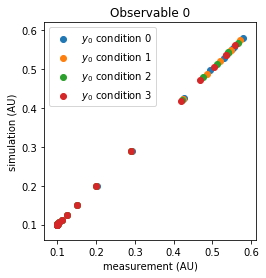

[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046616
 0.4009638  0.40199105 0.4041061  0.40843806 0.41721488 0.43460507
 0.46753068 0.52445703 0.60713044 0.69376801 0.73500837 0.70439349
 0.62886747 0.5355812 ] [0.40001082 0.40002239 0.40004633 0.40009586 0.40019832 0.40041019
 0.40084807 0.40175192 0.40361272 0.4074232  0.41514039 0.4304188
 0.45930092 0.50910688 0.58129786 0.65723318 0.69116124 0.65421259
 0.57584914 0.49131687]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046615
 0.40096376 0.40199086 0.40410531 0.40843473 0.41720084 0.43454691
 0.46729775 0.5235843  0.60424229 0.6861011  0.72067371 0.68526733
 0.60642    0.51180379] [0.40001082 0.40002239 0.40004633 0.40009586 0.40019832 0.40041018
 0.40084803 0.40175175 0.403612   0.40742014 0.41512749 0.43036529
 0.45908613 0.50829816 0.57859452 0.64993059 0.67722386 0.63534138
 0.55391813 0.46909646]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022537 0.40046614
 0.40096372 0.40199068 0.40410453 

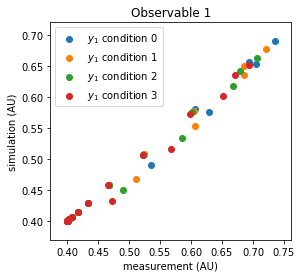

[0.6999792  0.69995696 0.69991095 0.69981577 0.69961885 0.6992116
 0.69836975 0.69663131 0.69304904 0.68569981 0.67075971 0.64095895
 0.58381563 0.4828983  0.33274096 0.17502923 0.08824506 0.06727818
 0.05651057 0.04468553] [0.6999804  0.69995944 0.69991609 0.69982639 0.69964082 0.69925703
 0.69846365 0.6968252  0.6934485  0.68651908 0.67242419 0.64427626
 0.59017542 0.49419811 0.35019115 0.19650899 0.10845089 0.08360403
 0.06880113 0.05447559]
[0.6999785  0.69995552 0.69990796 0.69980957 0.69960603 0.69918508
 0.69831495 0.6965182  0.69281623 0.68522334 0.66979577 0.63905514
 0.58023656 0.47681239 0.32424342 0.16659765 0.08234215 0.06252316
 0.05190231 0.04051998] [0.6999797  0.699958   0.69991309 0.69982019 0.699628   0.69923051
 0.69840884 0.69671206 0.69321557 0.68604204 0.67145792 0.64236285
 0.58655866 0.48797647 0.34128079 0.18714645 0.1011829  0.07741562
 0.06288309 0.04927101]
[0.6999778  0.69995407 0.69990496 0.69980337 0.6995932  0.69915856
 0.69826015 0.69640511 0.69258351 

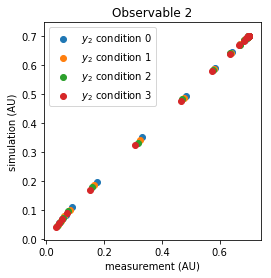

[0.2000356  0.20007366 0.20015241 0.20031533 0.2006524  0.20134958
 0.20279109 0.20576929 0.21191232 0.22454052 0.25031579 0.30212786
 0.4028219  0.58380281 0.8525968  1.1002188  1.15692673 1.11064669
 1.0570921  0.98989824] [0.166115   0.16614607 0.16621036 0.16634336 0.16661854 0.16718772
 0.16836467 0.17079659 0.17581419 0.18613464 0.20722353 0.24971089
 0.33263546 0.48276237 0.70788054 0.91679162 0.96610138 0.92786796
 0.88005648 0.8265741 ]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134956
 0.20279101 0.20576892 0.21191075 0.22453385 0.25028764 0.3020111
 0.40235471 0.58207915 0.84730771 1.08908853 1.14285653 1.09576545
 1.03970746 0.97057368] [0.166115   0.16614607 0.16621035 0.16634336 0.16661853 0.16718771
 0.16836461 0.17079631 0.175813   0.18612955 0.20720204 0.24962158
 0.33227691 0.48143228 0.70377024 0.90806059 0.95467749 0.9151341
 0.86517833 0.81073479]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134954
 0.20279092 0.20576855 0.21190918 0

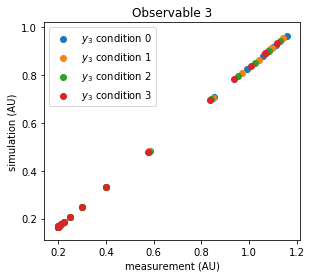

[3.4000123  3.40002545 3.40005266 3.40010894 3.40022538 3.40046616
 3.4009638  3.40199105 3.4041061  3.40843806 3.41721488 3.43460507
 3.46753068 3.52445703 3.60713044 3.69376801 3.73500837 3.70439349
 3.62886747 3.5355812 ] [3.53793097 3.53794254 3.53796648 3.53801601 3.53811846 3.53833034
 3.53876822 3.53967206 3.54153286 3.54534334 3.55306054 3.56833895
 3.59722106 3.64702702 3.71921801 3.79515332 3.82908139 3.79213274
 3.71376929 3.62923702]
[4.4000123  4.40002545 4.40005266 4.40010894 4.40022538 4.40046615
 4.40096376 4.40199086 4.40410531 4.40843473 4.41720084 4.43454691
 4.46729775 4.5235843  4.60424229 4.6861011  4.72067371 4.68526733
 4.60642    4.51180379] [4.61332266 4.61333423 4.61335817 4.6134077  4.61351015 4.61372202
 4.61415987 4.61506358 4.61692383 4.62073197 4.62843933 4.64367712
 4.67239796 4.72160999 4.79190636 4.86324243 4.89053569 4.84865321
 4.76722997 4.68240829]
[3.4000123  3.40002545 3.40005266 3.40010894 3.40022537 3.40046614
 3.40096372 3.40199068 3.40410453

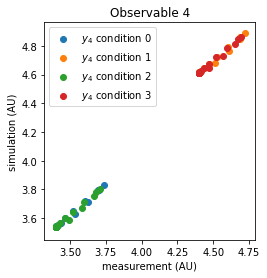

[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.1000175  0.10003621 0.10007491 0.100155   0.10032068 0.10066338
 0.10137202 0.10283627 0.10585736 0.11207128 0.12476886 0.15035041
 0.20027913 0.29067023 0.42621342 0.55199835 0.58168765 0.55866739
 0.52988019 0.49767856]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.1000175  0.10003621 0.10007491 0.100155   0.10032068 0.10066338
 0.10137198 0.1028361  0.10585664 0.11206822 0.12475592 0.15029664
 0.20006324 0.28986939 0.42373861 0.54674141 0.57480935 0.55100036
 0.52092209 0.48814175]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459

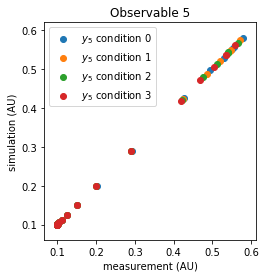

In [21]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

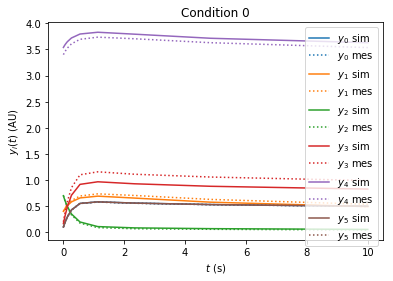

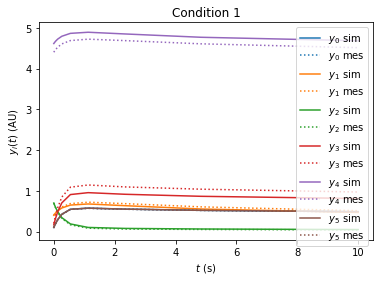

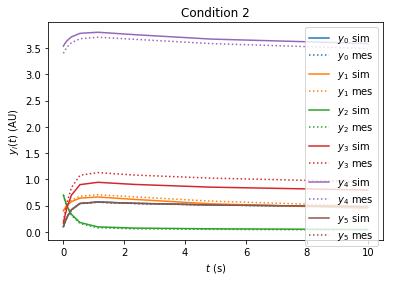

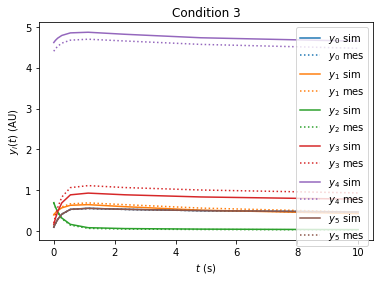

In [22]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)

## Hierarchical optimization

In [23]:
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 1
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            1
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

In [24]:
# gradient check 
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deleteme/ example_data.h5


HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 00:14:03] [WRN] [-1/]     0 g:     -7.62868  fd_c:     -7.62884  Δ/fd_c: -2.180263e-05  f:      72559.4
[2018-06-28 00:14:03] [WRN] [-1/]     1 g:     -7.59636  fd_c:     -7.59683  Δ/fd_c: -6.107484e-05  f:      72559.4
[2018-06-28 00:14:03] [INF] [-1/]     2 g:      8042.74  fd_c:      8042.74  Δ/fd_c: 2.824728e-07  f:      72559.4
[2018-06-28 00:14:03] [INF] [-1/]     3 g:     -133.339  fd_c:     -133.338  Δ/fd_c: 7.164667e-06  f:      72559.4
[2018-06-28 00:14:03] [INF] [-1/]     4 g:       353.34  fd_c:      353.342  Δ/fd_c: -5.251586e-06  f:      72559.4
[2018-06-28 00:14:03] [INF] [-1/] Walltime on master: 0.901000s, CPU time of all processes: 0.942151s


In [25]:
# optimization
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deleteme/ example_data.h5


[2018-06-28 00:14:03] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-06-28 00:14:03] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-06-28 00:14:03] [DBG] [3/dweindl] Seeding RNG with 1530137643
[2018-06-28 00:14:03] [DBG] [2/dweindl] Seeding RNG with 1530137643
[2018-06-28 00:14:03] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-06-28 00:14:03] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-06-28 00:14:03] [DBG] [0/dweindl] Seeding RNG with 1530137643
[2018-06-28 00:14:03] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-06-28 00:14:03] [DBG] [1/dweindl] Seeding RNG with 1530137643
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 00:14:03] [DBG] [3/dweindl] Writing results to deleteme/_rank00003.h5.
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 00:14:03] [DBG] [2/dweindl] Writing results to deleteme/_rank00002.h5.
HierachicalO

[2018-06-28 00:14:04] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -15880 (0) (0.0158s)
[2018-06-28 00:14:04] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -8880.01 (0) (0.0167s)
[2018-06-28 00:14:04] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -15880 (0) (0.0198s)
Total number of variables............................:        5
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2018-06-28 00:14:04] [INF] [0/dweindl] iter: 0 cost: 49520.1 time_iter: 0.654846s time_optim: 0.654847s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) al

[2018-06-28 00:14:11] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6570.56 (0) (0.0031s)
[2018-06-28 00:14:11] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12144.5 (0) (0.0023s)
[2018-06-28 00:14:11] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6599.97 (0) (0.0059s)
[2018-06-28 00:14:11] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12187.3 (0) (0.0039s)
[2018-06-28 00:14:11] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6570.56 (0) (0.0059s)
[2018-06-28 00:14:11] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12144.5 (0) (0.0081s)
[2018-06-28 00:14:11] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6554.22 (0) (0.5377s)
[2018-06-28 00:14:12] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12142.9 (0) (0.8126s)
[2018-06-28 00:14:13] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6527.51 (0) (0.6344s)
[2018-06-28 00:14:14] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12102.7 (0) (1.1100s)
[2018-06-28 00:14:14] [INF] [0/dweindl] iter: 5 cost: 37327.3 time_iter: 3.26962s time_optim: 10.416s
   5  3.7327334e+04 0.00e+00

[2018-06-28 00:14:27] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6534.45 (0) (0.4976s)
[2018-06-28 00:14:27] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12063.6 (0) (0.5218s)
[2018-06-28 00:14:28] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6516.97 (0) (0.9229s)
[2018-06-28 00:14:29] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12031.6 (0) (0.9497s)
[2018-06-28 00:14:29] [INF] [0/dweindl] iter: 11 cost: 37146.6 time_iter: 2.99726s time_optim: 25.7677s
  11  3.7146563e+04 0.00e+00 1.15e-01  -8.1 1.13e-02    -  1.00e+00 1.00e+00f  1
[2018-06-28 00:14:29] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.52 (0) (0.0064s)
[2018-06-28 00:14:29] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.1 (0) (0.0111s)
[2018-06-28 00:14:29] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.23 (0) (0.0059s)
[2018-06-28 00:14:29] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12085.6 (0) (0.0067s)
[2018-06-28 00:14:29] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.52 (0) (0.0063s)
[2018-06-28 00:14:29] [DBG] [0/d

[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.36 (0) (0.0035s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.3 (0) (0.0032s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.03 (0) (0.0033s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12085.7 (0) (0.0031s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.38 (0) (0.0033s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.3 (0) (0.0034s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.06 (0) (0.0034s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12085.7 (0) (0.0039s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.38 (0) (0.0033s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.3 (0) (0.0034s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.06 (0) (0.0033s)
[2018-06-28 00:14:43] [DBG] [0/dweindl] Res

[2018-06-28 00:14:58] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12031.3 (0) (0.4400s)
[2018-06-28 00:14:58] [INF] [0/dweindl] iter: 22 cost: 37146.5 time_iter: 1.99723s time_optim: 54.4483s
  22  3.7146537e+04 0.00e+00 1.75e-04  -9.0 2.17e-03    -  9.77e-01 1.00e+00f  1
[2018-06-28 00:14:58] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.49 (0) (0.0032s)
[2018-06-28 00:14:58] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.1 (0) (0.0063s)
[2018-06-28 00:14:58] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.19 (0) (0.0031s)
[2018-06-28 00:14:58] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12085.6 (0) (0.0030s)
[2018-06-28 00:14:58] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.49 (0) (0.0034s)
[2018-06-28 00:14:58] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.1 (0) (0.0034s)
[2018-06-28 00:14:58] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.19 (0) (0.0030s)
[2018-06-28 00:14:58] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12085.6 (0) (0.0032s)
[2018-06-28 00:14:58] [DBG] [0/d

[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.49 (0) (0.0086s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.1 (0) (0.0030s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.19 (0) (0.0027s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12085.6 (0) (0.0028s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.49 (0) (0.0045s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.1 (0) (0.0037s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.19 (0) (0.0031s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12085.6 (0) (0.0028s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6594.49 (0) (0.0028s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.1 (0) (0.0047s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.19 (0) (0.0030s)
[2018-06-28 00:15:00] [DBG] [0/dweindl] Res

[2018-06-28 00:15:01] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12121.1 (0) (0.0048s)
[2018-06-28 00:15:01] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6573.19 (0) (0.0032s)
[2018-06-28 00:15:01] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12085.6 (0) (0.0033s)
[2018-06-28 00:15:01] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6534.67 (0) (0.4739s)
[2018-06-28 00:15:02] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12063.3 (0) (0.4178s)
[2018-06-28 00:15:02] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6517.22 (0) (0.3997s)
[2018-06-28 00:15:02] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12031.3 (0) (0.4269s)
[2018-06-28 00:15:02] [INF] [0/dweindl] iter: 24 cost: 37146.5 time_iter: 2.62356s time_optim: 59.0469s
  24  3.7146537e+04 0.00e+00 1.38e-04 -11.0 4.25e-05    -  1.00e+00 7.28e-12f 38

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:   7.1335187417812983e+02    3.7146537313205183e+04
Dual infeasibility......:  

In [26]:
compareResults('deleteme/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 1000.000069 999.000069
1: 0.500000 0.000010 -0.499990
2: 0.400000 25.352650 24.952650
3: 2.000000 1000.000069 998.000069
4: 0.100000 0.288222 0.188222
5: 2.000000 2.068105 0.068105
6: 3.000000 1.000000 -2.000000
7: 100000000.000000 1.000000 -99999999.000000
8: 4.000000 1.000000 -3.000000
Status: 4
Cost: 37146.537313 (expected: 993.710918)


In [27]:
!rm simh.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank00000.h5 / simh.h5 / --at-optimum

Running for start 0
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


In [28]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.1000175  0.10003621 0.10007491 0.100155   0.10032068 0.10066338
 0.10137202 0.10283627 0.10585736 0.11207128 0.12476886 0.15035041
 0.20027913 0.29067023 0.42621342 0.55199835 0.58168765 0.55866739
 0.52988019 0.49767856]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.1000175  0.10003621 0.10007491 0.100155   0.10032068 0.10066338
 0.10137198 0.1028361  0.10585664 0.11206822 0.12475592 0.15029664
 0.20006324 0.28986939 0.42373861 0.54674141 0.57480935 0.55100036
 0.52092209 0.48814175]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459

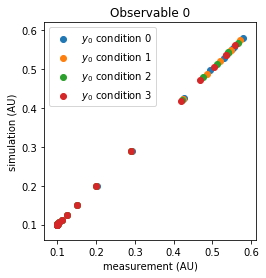

[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046616
 0.4009638  0.40199105 0.4041061  0.40843806 0.41721488 0.43460507
 0.46753068 0.52445703 0.60713044 0.69376801 0.73500837 0.70439349
 0.62886747 0.5355812 ] [0.40001082 0.40002239 0.40004633 0.40009586 0.40019832 0.40041019
 0.40084807 0.40175192 0.40361272 0.4074232  0.41514039 0.4304188
 0.45930092 0.50910688 0.58129786 0.65723318 0.69116124 0.65421259
 0.57584914 0.49131687]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046615
 0.40096376 0.40199086 0.40410531 0.40843473 0.41720084 0.43454691
 0.46729775 0.5235843  0.60424229 0.6861011  0.72067371 0.68526733
 0.60642    0.51180379] [0.40001082 0.40002239 0.40004633 0.40009586 0.40019832 0.40041018
 0.40084803 0.40175175 0.403612   0.40742014 0.41512749 0.43036529
 0.45908613 0.50829816 0.57859452 0.64993059 0.67722386 0.63534138
 0.55391813 0.46909646]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022537 0.40046614
 0.40096372 0.40199068 0.40410453 

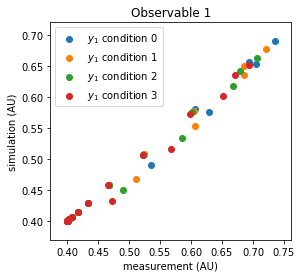

[0.6999792  0.69995696 0.69991095 0.69981577 0.69961885 0.6992116
 0.69836975 0.69663131 0.69304904 0.68569981 0.67075971 0.64095895
 0.58381563 0.4828983  0.33274096 0.17502923 0.08824506 0.06727818
 0.05651057 0.04468553] [0.6999804  0.69995944 0.69991609 0.69982639 0.69964082 0.69925703
 0.69846365 0.6968252  0.6934485  0.68651908 0.67242419 0.64427626
 0.59017542 0.49419811 0.35019115 0.19650899 0.10845089 0.08360403
 0.06880113 0.05447559]
[0.6999785  0.69995552 0.69990796 0.69980957 0.69960603 0.69918508
 0.69831495 0.6965182  0.69281623 0.68522334 0.66979577 0.63905514
 0.58023656 0.47681239 0.32424342 0.16659765 0.08234215 0.06252316
 0.05190231 0.04051998] [0.6999797  0.699958   0.69991309 0.69982019 0.699628   0.69923051
 0.69840884 0.69671206 0.69321557 0.68604204 0.67145792 0.64236285
 0.58655866 0.48797647 0.34128079 0.18714645 0.1011829  0.07741562
 0.06288309 0.04927101]
[0.6999778  0.69995407 0.69990496 0.69980337 0.6995932  0.69915856
 0.69826015 0.69640511 0.69258351 

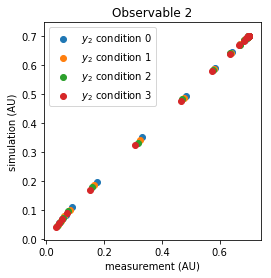

[0.2000356  0.20007366 0.20015241 0.20031533 0.2006524  0.20134958
 0.20279109 0.20576929 0.21191232 0.22454052 0.25031579 0.30212786
 0.4028219  0.58380281 0.8525968  1.1002188  1.15692673 1.11064669
 1.0570921  0.98989824] [0.166115   0.16614607 0.16621036 0.16634336 0.16661854 0.16718772
 0.16836467 0.17079659 0.17581419 0.18613464 0.20722353 0.24971089
 0.33263546 0.48276237 0.70788054 0.91679162 0.96610138 0.92786796
 0.88005648 0.8265741 ]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134956
 0.20279101 0.20576892 0.21191075 0.22453385 0.25028764 0.3020111
 0.40235471 0.58207915 0.84730771 1.08908853 1.14285653 1.09576545
 1.03970746 0.97057368] [0.166115   0.16614607 0.16621035 0.16634336 0.16661853 0.16718771
 0.16836461 0.17079631 0.175813   0.18612955 0.20720204 0.24962158
 0.33227691 0.48143228 0.70377024 0.90806059 0.95467749 0.9151341
 0.86517833 0.81073479]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134954
 0.20279092 0.20576855 0.21190918 0

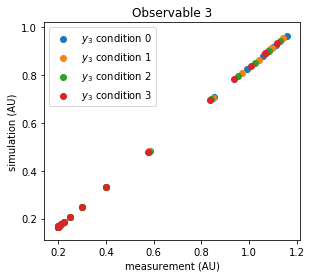

[3.4000123  3.40002545 3.40005266 3.40010894 3.40022538 3.40046616
 3.4009638  3.40199105 3.4041061  3.40843806 3.41721488 3.43460507
 3.46753068 3.52445703 3.60713044 3.69376801 3.73500837 3.70439349
 3.62886747 3.5355812 ] [3.53793097 3.53794254 3.53796648 3.53801601 3.53811846 3.53833034
 3.53876822 3.53967206 3.54153286 3.54534334 3.55306054 3.56833895
 3.59722106 3.64702702 3.71921801 3.79515332 3.82908139 3.79213274
 3.71376929 3.62923702]
[4.4000123  4.40002545 4.40005266 4.40010894 4.40022538 4.40046615
 4.40096376 4.40199086 4.40410531 4.40843473 4.41720084 4.43454691
 4.46729775 4.5235843  4.60424229 4.6861011  4.72067371 4.68526733
 4.60642    4.51180379] [4.61332266 4.61333423 4.61335817 4.6134077  4.61351015 4.61372202
 4.61415987 4.61506358 4.61692383 4.62073197 4.62843933 4.64367712
 4.67239796 4.72160999 4.79190636 4.86324243 4.89053569 4.84865321
 4.76722997 4.68240829]
[3.4000123  3.40002545 3.40005266 3.40010894 3.40022537 3.40046614
 3.40096372 3.40199068 3.40410453

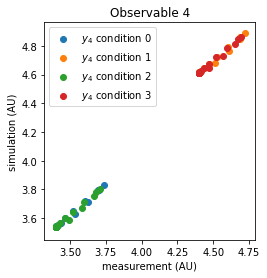

[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.1000175  0.10003621 0.10007491 0.100155   0.10032068 0.10066338
 0.10137202 0.10283627 0.10585736 0.11207128 0.12476886 0.15035041
 0.20027913 0.29067023 0.42621342 0.55199835 0.58168765 0.55866739
 0.52988019 0.49767856]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.1000175  0.10003621 0.10007491 0.100155   0.10032068 0.10066338
 0.10137198 0.1028361  0.10585664 0.11206822 0.12475592 0.15029664
 0.20006324 0.28986939 0.42373861 0.54674141 0.57480935 0.55100036
 0.52092209 0.48814175]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459

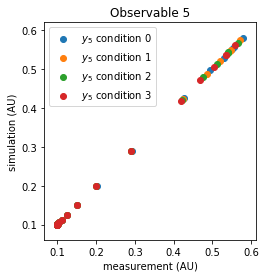

In [29]:
plotCorrelation(ymes, ysim)

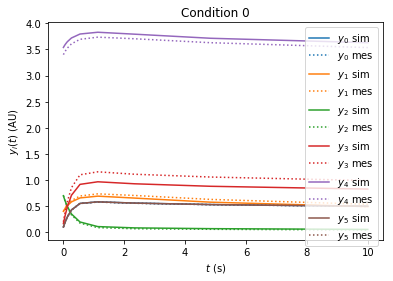

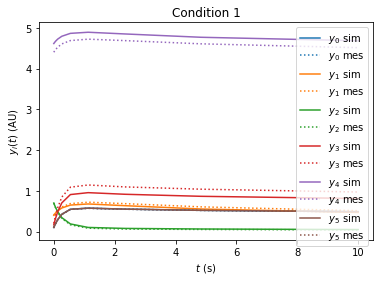

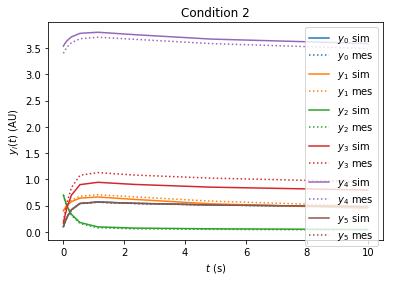

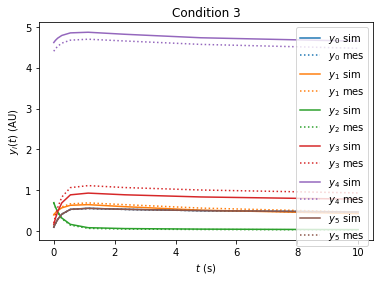

In [30]:
plotTrajectoryFit(ymes, ysim, timepoints)

## Ceres

In [31]:
!../../../misc/optimizationOptions.py example_data.h5 -s optimizer 1
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deleteme/ example_data.h5


[2018-06-28 00:15:08] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-06-28 00:15:08] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-06-28 00:15:08] [DBG] [1/dweindl] Seeding RNG with 1530137708
[2018-06-28 00:15:08] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-06-28 00:15:08] [DBG] [2/dweindl] Seeding RNG with 1530137708
[2018-06-28 00:15:08] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-06-28 00:15:08] [DBG] [3/dweindl] Seeding RNG with 1530137708
[2018-06-28 00:15:08] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-06-28 00:15:08] [DBG] [0/dweindl] Seeding RNG with 1530137708
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 00:15:08] [DBG] [2/dweindl] Writing results to deleteme/_rank00002.h5.
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 00:15:08] [DBG] [1/dweindl] Writing results to deleteme/_rank00001.h5.
HierachicalO

[2018-06-28 00:15:15] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6936.62 (0) (0.0025s)
[2018-06-28 00:15:15] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12720.6 (0) (0.0022s)
[2018-06-28 00:15:15] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6921.47 (0) (0.0021s)
[2018-06-28 00:15:15] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12691.5 (0) (0.0065s)
[2018-06-28 00:15:15] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6933.14 (0) (0.4521s)
[2018-06-28 00:15:16] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12716.5 (0) (0.4696s)
[2018-06-28 00:15:16] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6916.78 (0) (0.3678s)
[2018-06-28 00:15:16] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12686.2 (0) (0.3631s)
line_search.cc:584 Line search failed: Wolfe bracketing phase shrank bracket width: 0, to < tolerance: 1e-09, with descent_direction_max_norm: 1379.89, and failed to find a point satisfying the strong Wolfe conditions or a bracketing containing such a point. Accepting point found satisfying Armijo condi

In [32]:
compareResults('deleteme/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 4.237539 3.237539
1: 0.500000 1.318055 0.818055
2: 0.400000 0.867851 0.467851
3: 2.000000 999.999730 997.999730
4: 0.100000 0.344016 0.244016
5: 2.000000 0.883555 -1.116445
6: 3.000000 1.000000 -2.000000
7: 100000000.000000 1.000000 -99999999.000000
8: 4.000000 1.000000 -3.000000
Status: 0
Cost: 39237.310149 (expected: 993.710918)


# TODO

## preeequilibration
## different optimizers
## improve timing